#Imports 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re       # for emojis source https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import nltk     #for stop words
from nltk.tokenize import word_tokenize #for stopwords
from nltk.corpus import stopwords

from tensorflow.keras import layers


In [5]:
nltk.download("stopwords") 
nltk.download('punkt')
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [55]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.strings import regex_replace
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GRU #
from keras import regularizers
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import zipfile
from collections import Counter
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
import seaborn as sn
from tensorflow.keras.regularizers import l1_l2

# Formatting and Reading Data

In [8]:
dataframe = pd.read_csv('/content/drive/MyDrive/Tweets.csv')

In [9]:
dataframe.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [10]:
dataframe['target'] = dataframe['airline_sentiment']
dataframe['data'] = dataframe['text']

#Preprocessing 

In [11]:
# Change target from words to a numeric scale 0-neutral,1 negative, 2 positive
def convert_Sentiment(val):
    if  val == "positive":
        return 2
    elif val == "neutral":
        return 0
    elif val == "negative":
        return 1

In [12]:
dataframe.target = dataframe.target.apply(lambda val : convert_Sentiment(val))

In [13]:
Counter(dataframe.target)

Counter({0: 3099, 1: 9178, 2: 2363})

In [14]:
dataframe['predata'] = dataframe['negativereason'].fillna('') + ' ' + dataframe['data']

In [18]:
## Preprocess 
def all_preprocessing(text):
  
  # Removes usernames eg. @UnitediAIrlines 
  text= re.sub('@[^\s]+','',text)
  
  # Remove url  
  url = re.compile(r'https?://\S+|www\.\S+')
  text= url.sub(r'',text)
  
  #removes emojis from text 
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
  text=(emoji_pattern.sub(r'', text)) # no emoji
  
  # removes puntuation from text 
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  no_punct = ""
  for char in text:
    if char not in punctuations:
        no_punct = no_punct + char
  text=no_punct

  # removes stop words 
  
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
  STWfree = (" ").join(tokens_without_sw)
  text=STWfree

  # remove html line breaks with space 
  text=re.sub(r'<.*?>','',text)
  
  #converts all word to lower caase 
  text=text.lower()

  #removing all numbers
  text = ''.join([i for i in text if not i.isdigit()])
  
  return text

In [19]:
dataframe.predata = dataframe.predata.apply(lambda x : all_preprocessing(x))

In [20]:
print(dataframe['predata'])

0                                                     said
1            plus youve added commercials experience tacky
2             didnt today must mean need take another trip
3        bad flight really aggressive blast obnoxious e...
4                           cant tell really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    customer service issue leaving minutes late fl...
14637            please bring american airlines blackberry
14638    customer service issue money change flight don...
14639    ppl need know many seats next flight plz put u...
Name: predata, Length: 14640, dtype: object


In [21]:
dataframe = dataframe.drop(columns=['tweet_id', 'airline_sentiment','airline_sentiment_confidence','negativereason','negativereason_confidence','airline','airline_sentiment_gold','name','negativereason_gold','retweet_count','text','tweet_coord','tweet_created','tweet_location','user_timezone','data'])

In [22]:
ALL_Data=[]
ALL_Labels=[]
#(dataframe['predata'])
ALL_Data= dataframe[['predata']].to_numpy()
ALL_Labels=dataframe[['target']].to_numpy()

In [23]:
print(ALL_Data.shape)
print(ALL_Labels.shape)

(14640, 1)
(14640, 1)


In [24]:
ALL_Data=ALL_Data.reshape(-1)
ALL_Labels=ALL_Labels.reshape(-1)

In [25]:
print(ALL_Data)

['said' 'plus youve added commercials experience tacky'
 'didnt today must mean need take another trip' ...
 'please bring american airlines blackberry'
 'customer service issue money change flight dont answer phones suggestions make commitment'
 'ppl need know many seats next flight plz put us standby people next flight']


In [26]:
print(ALL_Labels)

[0 2 0 ... 0 1 0]


# Balancing Dataset

In [27]:
Counter(ALL_Labels)

Counter({0: 3099, 1: 9178, 2: 2363})

In [28]:
ALL_Data=ALL_Data.reshape(-1,1)
ALL_Labels=ALL_Labels.reshape(-1,1)

In [29]:
#fix imbalanced data
oversample = RandomOverSampler(sampling_strategy='all')
X_over, y_over = oversample.fit_resample(ALL_Data, ALL_Labels)

In [30]:
ALL_Data=X_over.reshape(-1)
ALL_Labels=y_over.reshape(-1)

In [31]:
print(ALL_Labels.shape)
print(ALL_Data.shape)

(27534,)
(27534,)


In [32]:
Counter(ALL_Labels)

Counter({0: 9178, 1: 9178, 2: 9178})

In [33]:
print(ALL_Labels)

[0 2 0 ... 2 2 2]


# Train Test Split

In [34]:
ALL_Labels = to_categorical(ALL_Labels, 3)

In [35]:
print(ALL_Labels.shape)

(27534, 3)


In [36]:
(trainX, testX, trainY, testY) = train_test_split(ALL_Data,ALL_Labels, test_size = 0.40)

In [37]:
print(trainX.shape)
print(trainY.shape)

(16520,)
(16520, 3)


In [38]:
print(testX.shape)
print(testY.shape)

(11014,)
(11014, 3)


#Benchmark

Model only one fully connected recurrent layer

In [36]:
#maxTokens = 1000
vectorizeLayer = TextVectorization(output_mode = 'int')
vectorizeLayer.adapt(trainX)
model = Sequential()

model.add(Input(shape=(1,), dtype = 'string'))

# add layer to the model
model.add(vectorizeLayer)

# add an embedding layer to turn integers into fixed-length vectors
#model.add(Embedding(maxTokens + 1, 128))
model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
# add a dense layer
model.add(Dense(64, activation = 'relu'))

# add a dense layer
model.add(Dense(64, activation = 'relu'))

model.add(SimpleRNN(64))
# add softmax classifier
model.add(Dense(3, activation = 'softmax'))

In [37]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 128)         1329536   
                                                                 
 dense (Dense)               (None, None, 64)          8256      
                                                                 
 dense_1 (Dense)             (None, None, 64)          4160      
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                        

Epoch 1/10
413/413 [==============================] - 10s 19ms/step - loss: 0.8051 - acc: 0.5555 - val_loss: 0.6495 - val_acc: 0.6392
Epoch 2/10
413/413 [==============================] - 7s 18ms/step - loss: 0.6539 - acc: 0.6378 - val_loss: 0.5432 - val_acc: 0.6531
Epoch 3/10
413/413 [==============================] - 7s 18ms/step - loss: 0.5298 - acc: 0.6559 - val_loss: 0.5212 - val_acc: 0.6544
Epoch 4/10
413/413 [==============================] - 7s 18ms/step - loss: 0.5151 - acc: 0.6614 - val_loss: 0.5130 - val_acc: 0.6577
Epoch 5/10
413/413 [==============================] - 7s 18ms/step - loss: 0.4997 - acc: 0.6687 - val_loss: 0.4994 - val_acc: 0.6752
Epoch 6/10
413/413 [==============================] - 7s 18ms/step - loss: 0.5138 - acc: 0.6640 - val_loss: 0.5681 - val_acc: 0.6798
Epoch 7/10
413/413 [==============================] - 8s 18ms/step - loss: 0.7374 - acc: 0.5996 - val_loss: 1.0834 - val_acc: 0.3720
Epoch 8/10
413/413 [==============================] - 7s 18ms/step -

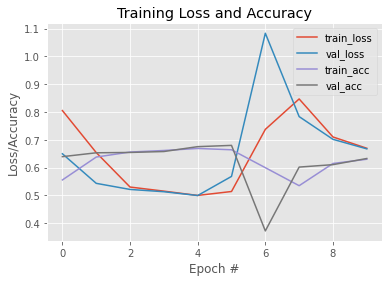

In [38]:
epochs = 10

H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()


Train Accuracy
              precision    recall  f1-score   support

           0       0.49      0.28      0.36      5523
           1       0.90      0.93      0.91      5520
           2       0.51      0.72      0.60      5477

    accuracy                           0.64     16520
   macro avg       0.64      0.64      0.62     16520
weighted avg       0.64      0.64      0.62     16520



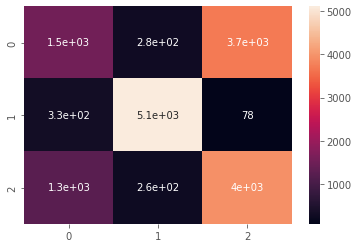

In [39]:
# printing classification report for Training Data
print('\nTrain Accuracy')
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainyTB = trainY.argmax(axis=1)
print(classification_report(trainyTB, predictedY))
heatmap(confusion_matrix(trainyTB, predictedY), annot=True)

Overfitting occurs in the bench mark cn be seen from how the accuracy stagnates.For experiments the architecture of the benchmark will be built on, overfitting will be reduced and other models will be tested.


# Experiment 1-Using dropout layers to mitigate overfitting.

In [40]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))

    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    model.add(SimpleRNN(64))
    # add a dense layer
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         1329536   
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

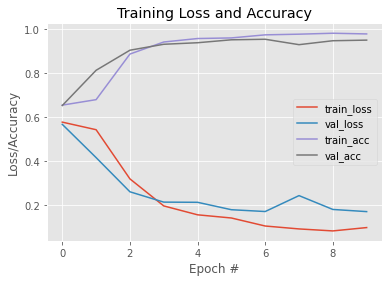

In [41]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Experiment 2 - Using regularization on Dense layers to mitigate overfitting

In [57]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    #model.add(Dropout(dropout[0]))

    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    model.add(SimpleRNN(64))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, None, 128)         1329536   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,346,243
Trainable params: 1,346,243
Non-trainable params: 0
____________________________________________

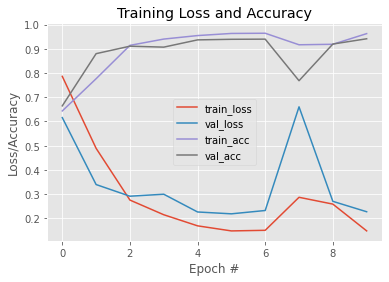

In [51]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs)

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#Experiment 3 implementing early stopping to help mitigate overfitting 

In [59]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    #model.add(Dropout(dropout[0]))

    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    model.add(SimpleRNN(64))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_11 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_11 (Embedding)    (None, None, 128)         1329536   
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,346,243
Trainable params: 1,346,243
Non-trainable params: 0
___________________________________________

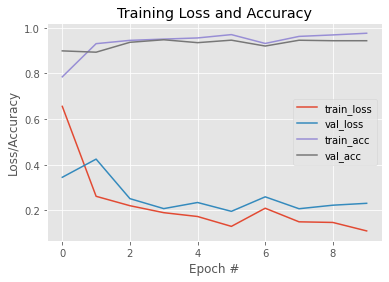

In [65]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Experiment 4 -impleneting birectional RNN and  RNN

In [74]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    
    model.add(SimpleRNN(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    
    model.add(Bidirectional(SimpleRNN(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_16 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_16 (Embedding)    (None, None, 128)         1329536   
                                                                 
 dropout_10 (Dropout)        (None, None, 128)         0         
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, None, 64)          12352     
                                                                 
 dropout_11 (Dropout)        (None, None, 64)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 128)              16512     
 nal)                                                

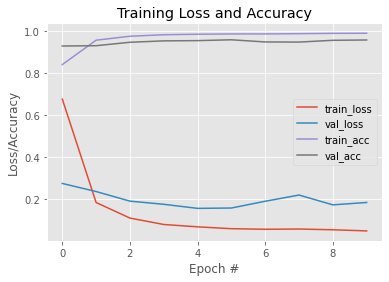

In [75]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#Experiment 5  using LSTM 

In [66]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    #model.add(Dropout(dropout[0]))

    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    model.add(LSTM(64))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_12 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_12 (Embedding)    (None, None, 128)         1329536   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 3)                 195       
                                                                 
Total params: 1,383,299
Trainable params: 1,383,299
Non-trainable params: 0
___________________________________________

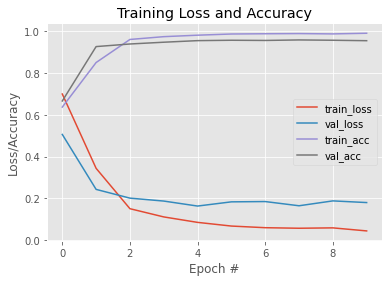

In [67]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#Experiment 6 - GRU

In [41]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    # add a fully-connected recurrent layer
    model.add(Dropout(dropout[1]))
    #model.add(Bidirectional(SimpleRNN(64)))
    model.add(GRU(units=50, activation='tanh'))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 128)         1325312   
                                                                 
 dropout_3 (Dropout)         (None, None, 128)         0         
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 50)                27000     
                                                                 
 dense_2 (Dense)             (None, 64)                3264      
                                                      

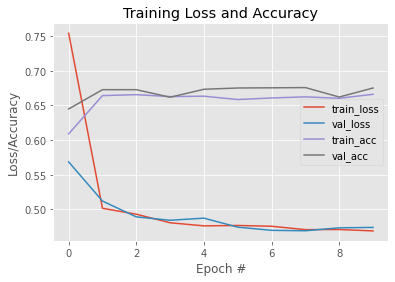

In [42]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Experiment 7 using both bidirectional and  LTSM

In [72]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    
    model.add(Bidirectional(LSTM(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_15 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_15 (Embedding)    (None, None, 128)         1329536   
                                                                 
 dropout_7 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_4 (LSTM)               (None, None, 64)          49408     
                                                                 
 dropout_8 (Dropout)         (None, None, 64)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              66048     
 nal)                                                

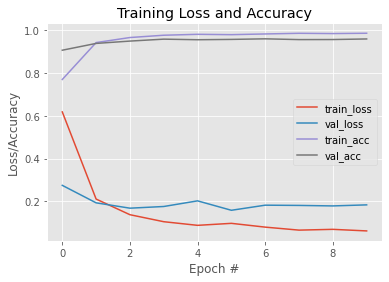

In [73]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#Experiment bidirectional lstm and GRU 

In [89]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))

    model.add(GRU(units=50, activation='tanh',return_sequences = True))
    #model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    
    model.add(Bidirectional(LSTM(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_22 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_20 (Embedding)    (None, None, 128)         1329536   
                                                                 
 dropout_18 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, None, 50)          27000     
                                                                 
 dropout_19 (Dropout)        (None, None, 50)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              58880     
 nal)                                                

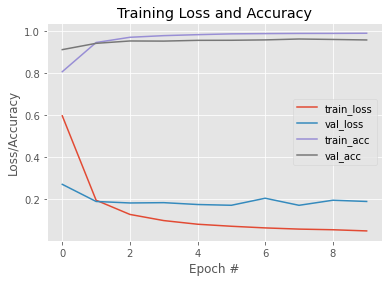

In [91]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

# Experiment 9 using lstm and bidirection rnn

In [92]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))

    model.add(GRU(units=50, activation='tanh',return_sequences = True))
    #model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    
    model.add(Bidirectional(SimpleRNN(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_23 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_21 (Embedding)    (None, None, 128)         1329536   
                                                                 
 dropout_21 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_2 (GRU)                 (None, None, 50)          27000     
                                                                 
 dropout_22 (Dropout)        (None, None, 50)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              14720     
 nal)                                                

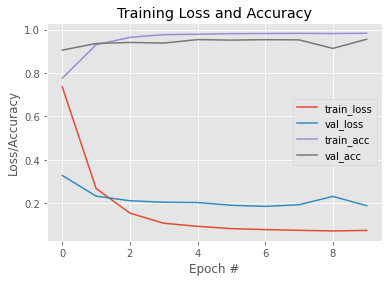

In [93]:
epochs = 10
#dropout=[[0.2,0.0,0.5],]
es = EarlyStopping(monitor='val_loss',patience=5)
model = experiment2.build(dropout=[0.2,0.0,0.5])
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])
model.summary()
H = model.fit(trainX,trainY,validation_split=0.2,epochs = epochs,callbacks=[es])

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, epochs), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0, epochs), H.history['acc'], label = 'train_acc')
plt.plot(np.arange(0, epochs), H.history['val_acc'], label = 'val_acc')
    
# add labels and legend
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()

#Experiemnt 10 best of previous models with regularization on layers , dropout and early stoping  

In [45]:
class experiment2:
  def build(dropout=[[0,0,0]]):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    
    model.add(SimpleRNN(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    
    model.add(Bidirectional(SimpleRNN(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

In [46]:
from sklearn.metrics import accuracy_score
epochs = 10
es = EarlyStopping(monitor='val_loss',patience=5)
for dropout in [[0.1,0.2,0.2],[0,0.01,0.05],[0.5, 0.1, 0.2]]:
        
    model = experiment2.build(dropout=dropout)
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

    maxIt = 10
    H = model.fit(trainX, trainY, validation_split = 0.20, batch_size =32, epochs = maxIt)
    print('Dev accuracy for dropout percentages', dropout, 'is', H.history['val_acc'][-1])


Epoch 1/10
413/413 [==============================] - 11s 15ms/step - loss: 0.5639 - acc: 0.8160 - val_loss: 0.2529 - val_acc: 0.9192
Epoch 2/10
413/413 [==============================] - 4s 11ms/step - loss: 0.1809 - acc: 0.9503 - val_loss: 0.1817 - val_acc: 0.9440
Epoch 3/10
413/413 [==============================] - 4s 11ms/step - loss: 0.1171 - acc: 0.9711 - val_loss: 0.1627 - val_acc: 0.9546
Epoch 4/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0945 - acc: 0.9777 - val_loss: 0.1780 - val_acc: 0.9519
Epoch 5/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0799 - acc: 0.9806 - val_loss: 0.1792 - val_acc: 0.9519
Epoch 6/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0767 - acc: 0.9823 - val_loss: 0.1920 - val_acc: 0.9558
Epoch 7/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0679 - acc: 0.9840 - val_loss: 0.1703 - val_acc: 0.9564
Epoch 8/10
413/413 [==============================] - 5s 11ms/step -

# Trying L2 regularization

In [58]:
class experiment2:
  def build(l1=0,l2=0):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    
    model.add(Bidirectional(LSTM(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer= l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

In [61]:
from sklearn.metrics import accuracy_score
epochs = 10
es = EarlyStopping(monitor='val_loss',patience=5)
for l1 in [0, 0.001, 0.01, 0.1]:
  for l2 in [0, 0.001, 0.01, 0.1]:
      model = experiment2.build(l1/trainX.shape[0], l2/trainX.shape[0])
      model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

      maxIt = 10
      H = model.fit(trainX, trainY, validation_split = 0.20, batch_size =32, epochs = maxIt,verbose = 0,callbacks=[es])
      dev_accuracy = H.history['val_acc'][-1]
      print('Dev accuracy for l1 =', l1, ', l2 =', l2, 'is', dev_accuracy)

Dev accuracy for l1 = 0 , l2 = 0 is 0.9621670842170715
Dev accuracy for l1 = 0 , l2 = 0.001 is 0.9582324624061584
Dev accuracy for l1 = 0 , l2 = 0.01 is 0.9542978405952454
Dev accuracy for l1 = 0 , l2 = 0.1 is 0.9603511095046997
Dev accuracy for l1 = 0.001 , l2 = 0 is 0.9546005129814148
Dev accuracy for l1 = 0.001 , l2 = 0.001 is 0.9558111429214478
Dev accuracy for l1 = 0.001 , l2 = 0.01 is 0.9606537818908691
Dev accuracy for l1 = 0.001 , l2 = 0.1 is 0.9594430923461914
Dev accuracy for l1 = 0.01 , l2 = 0 is 0.9564164876937866
Dev accuracy for l1 = 0.01 , l2 = 0.001 is 0.9594430923461914
Dev accuracy for l1 = 0.01 , l2 = 0.01 is 0.9488498568534851
Dev accuracy for l1 = 0.01 , l2 = 0.1 is 0.9582324624061584
Dev accuracy for l1 = 0.1 , l2 = 0 is 0.9555084705352783
Dev accuracy for l1 = 0.1 , l2 = 0.001 is 0.9609563946723938
Dev accuracy for l1 = 0.1 , l2 = 0.01 is 0.9539951682090759
Dev accuracy for l1 = 0.1 , l2 = 0.1 is 0.9588377475738525


#TEST 

In [62]:
class experiment2:
  def build(dropout=[0,0.1,0.5],l1=0.1,l2=0.001):
    vectorizeLayer = TextVectorization(output_mode = 'int')

    # adapt() fits the TextVectorization layer to our text dataset. This is when the
    vectorizeLayer.adapt(trainX)

    model = Sequential()

    model.add(Input(shape=(1,), dtype = 'string'))

    # text vectorization layer
    model.add(vectorizeLayer)

    # add an embedding layer to turn integers into fixed-length vectors
    model.add(Embedding(vectorizeLayer.vocabulary_size(), 128))
    model.add(Dropout(dropout[0]))
    
    model.add(LSTM(64, return_sequences = True))
    model.add(Dropout(dropout[1]))
    # add a fully-connected recurrent layer
    #model.add(Bidirectional(SimpleRNN(64)))
    
    model.add(Bidirectional(LSTM(64)))
    # add a dense layer
    model.add(Dense(64, activation = 'relu',kernel_regularizer= l1_l2(l1=l1, l2=l2)))
    model.add(Dropout(dropout[2]))

    # add softmax classifier
    model.add(Dense(3, activation = 'softmax'))
    return model

Epoch 1/10
413/413 [==============================] - 5s 12ms/step - loss: 0.0471 - acc: 0.9860 - val_loss: 0.1910 - val_acc: 0.9528
Epoch 2/10
413/413 [==============================] - 5s 12ms/step - loss: 0.0424 - acc: 0.9869 - val_loss: 0.1989 - val_acc: 0.9591
Epoch 3/10
413/413 [==============================] - 5s 11ms/step - loss: 0.0404 - acc: 0.9874 - val_loss: 0.2031 - val_acc: 0.9600
Epoch 4/10
413/413 [==============================] - 5s 11ms/step - loss: 0.0396 - acc: 0.9870 - val_loss: 0.2091 - val_acc: 0.9558
Epoch 5/10
413/413 [==============================] - 5s 11ms/step - loss: 0.0352 - acc: 0.9887 - val_loss: 0.2116 - val_acc: 0.9613
Epoch 6/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0354 - acc: 0.9883 - val_loss: 0.2334 - val_acc: 0.9594
Epoch 7/10
413/413 [==============================] - 4s 10ms/step - loss: 0.0357 - acc: 0.9892 - val_loss: 0.2246 - val_acc: 0.9576
Epoch 8/10
413/413 [==============================] - 4s 10ms/step - 

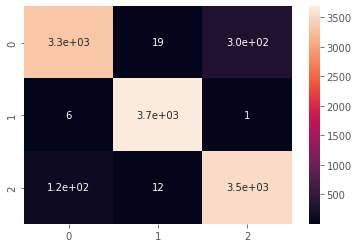

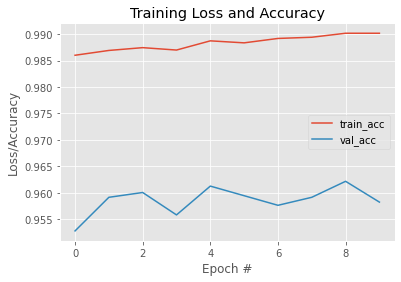

In [63]:
maxIt = 10
H = model.fit(trainX, trainY, validation_split = 0.20, epochs = maxIt)

print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testYC = testY.argmax(axis=1)
print(classification_report(testYC, predictedY))

sn.heatmap(confusion_matrix(testYC, predictedY), annot = True)
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0, maxIt), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

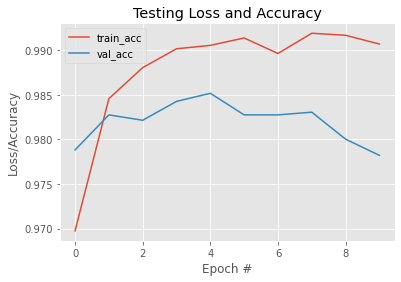

In [120]:
plt.plot(np.arange(0, maxIt), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, maxIt), H.history["val_acc"], label="val_acc")
plt.title("Testing Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()